<a href="https://colab.research.google.com/github/nehaal10/Cloud_deployment/blob/main/credit_risk_assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import shutil
import pandas as pd

In [ ]:
os.chdir('/content/drive/MyDrive/kaggle')

In [ ]:
os.environ['KAGGLE_CONFIG_DIR']=os.getcwd()
!kaggle competitions download -c home-credit-default-risk

 99% 680M/688M [00:09<00:00, 131MB/s]
100% 688M/688M [00:09<00:00, 78.8MB/s]


In [ ]:
os.mkdir('/content/drive/MyDrive/project')
shutil.move('/content/drive/MyDrive/kaggle/home-credit-default-risk.zip','/content/drive/MyDrive/project')

'/content/drive/MyDrive/project/home-credit-default-risk.zip'

In [ ]:
os.chdir('/content/drive/MyDrive/project')
!unzip -q 'home-credit-default-risk.zip'

In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from sklearn.model_selection import train_test_split
init_notebook_mode(connected=True)
import cufflinks as cf
cf.go_offline()
import pickle
import gc
import lightgbm as lgb
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
os.chdir('/content/drive/MyDrive/project')

In [ ]:
print('Reading the data....', end='')
application = pd.read_csv('application_train.csv')
print('done!!!')
print('The shape of data:',application.shape)
print('First 5 rows of data:')
application=application.loc[:60000,:]
application.shape

Reading the data....done!!!
The shape of data: (307511, 122)
First 5 rows of data:


(60001, 122)

In [ ]:
application.shape

(60001, 122)

In [ ]:
count = application.isnull().sum().sort_values(ascending=False)
percentage = ((application.isnull().sum()/len(application)*100)).sort_values(ascending=False)
missing_application = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
print('Count and percentage of missing values for top 20 columns:')
missing_application.head(20)

Count and percentage of missing values for top 20 columns:


,Count,Percentage
COMMONAREA_MEDI,41908,69.845503
COMMONAREA_AVG,41908,69.845503
COMMONAREA_MODE,41908,69.845503
NONLIVINGAPARTMENTS_MODE,41635,69.390510
NONLIVINGAPARTMENTS_AVG,41635,69.390510
NONLIVINGAPARTMENTS_MEDI,41635,69.390510
LIVINGAPARTMENTS_MODE,41037,68.393860
LIVINGAPARTMENTS_AVG,41037,68.393860
LIVINGAPARTMENTS_MEDI,41037,68.393860
FONDKAPREMONT_MODE,40979,68.297195


In [ ]:
columns_without_id = [col for col in application.columns if col!='SK_ID_CURR']
#Checking for duplicates in the data.
application[application.duplicated(subset = columns_without_id, keep=False)]
print('The no of duplicates in the data:',application[application.duplicated(subset = columns_without_id, keep=False)]
      .shape[0])

The no of duplicates in the data: 0


In [ ]:
(application[application['AMT_INCOME_TOTAL'] > 1000000]['TARGET'].value_counts())/len(application[application['AMT_INCOME_TOTAL'] > 1000000])*100

0    93.333333
1     6.666667
Name: TARGET, dtype: float64

In [ ]:
application['AMT_CREDIT']=np.log(application['AMT_CREDIT'])

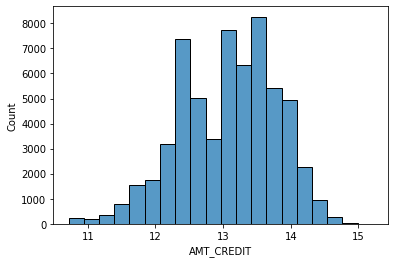

In [ ]:
sns.histplot(x='AMT_CREDIT',data=application,bins=20)

In [ ]:
cf.set_config_file(theme='polar')
suite_val = (application['NAME_TYPE_SUITE'].value_counts()/len(application))*100
suite_val.iplot(kind='bar', xTitle = 'Name of type of the Suite',
             yTitle='Count of applicants in %',
             title='Who accompanied client when applying for the  application in % ')

In [ ]:
suite_val = application['NAME_TYPE_SUITE'].value_counts()
suite_val_y0 = []
suite_val_y1 = []
for val in suite_val.index:
    suite_val_y1.append(np.sum(application['TARGET'][application['NAME_TYPE_SUITE']==val] == 1))
    suite_val_y0.append(np.sum(application['TARGET'][application['NAME_TYPE_SUITE']==val] == 0))
data = [go.Bar(x = suite_val.index, y = ((suite_val_y1 / suite_val.sum()) * 100), name='Yes' ),
        go.Bar(x = suite_val.index, y = ((suite_val_y0 / suite_val.sum()) * 100), name='No' )]
layout = go.Layout(
    title = "Who accompanied client when applying for the  application in terms of loan is repayed or not in %",
    xaxis=dict(
        title='Name of type of the Suite',
       ),
    yaxis=dict(
        title='Count of applicants in %',
        )
)
fig = go.Figure(data = data, layout=layout) 
fig.layout.template = 'plotly_dark'
py.iplot(fig)

In [ ]:
income_val = application['NAME_INCOME_TYPE'].value_counts()
income_val_y0 = []
income_val_y1 = []
for val in income_val.index:
    income_val_y1.append(np.sum(application['TARGET'][application['NAME_INCOME_TYPE']==val] == 1))
    income_val_y0.append(np.sum(application['TARGET'][application['NAME_INCOME_TYPE']==val] == 0))
data = [go.Bar(x = income_val.index, y = ((income_val_y1 / income_val.sum()) * 100), name='Yes' ),
        go.Bar(x = income_val.index, y = ((income_val_y0 / income_val.sum()) * 100), name='No' )]
layout = go.Layout(
    title = "Income sources of Applicants in terms of loan is repayed or not  in %",
    xaxis=dict(
        title='Income source',
       ),
    yaxis=dict(
        title='Count of applicants in %',
        )
)
fig = go.Figure(data = data, layout=layout) 
fig.layout.template = 'plotly_dark'
py.iplot(fig)

In [ ]:
error = application[application['DAYS_EMPLOYED'] == 365243]
print('The no of errors are :', len(error))
(error['TARGET'].value_counts()/len(error))*100

The no of errors are : 10671


0    94.414769
1     5.585231
Name: TARGET, dtype: float64

In [ ]:
# Create an error flag column
application['DAYS_EMPLOYED_ERROR'] = application["DAYS_EMPLOYED"] == 365243
# Replace the error values with nan
application['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [ ]:
cf.set_config_file(theme='pearl')
(application['DAYS_EMPLOYED']/(-365)).iplot(kind='histogram', xTitle = 'Years of Employment',bins=50,
             yTitle='Count of applicants in %',
             title='Years before the application the person started current employment')

In [ ]:
application[application['DAYS_EMPLOYED']>(-365*2)]['TARGET'].value_counts()/sum(application['DAYS_EMPLOYED']>(-365*2))

0    0.888282
1    0.111718
Name: TARGET, dtype: float64

In [ ]:
# Flag to represent when Total income is greater than Credit
application['INCOME_GT_CREDIT_FLAG'] = application['AMT_INCOME_TOTAL'] > application['AMT_CREDIT']
# Column to represent Credit Income Percent
application['CREDIT_INCOME_PERCENT'] = application['AMT_CREDIT'] / application['AMT_INCOME_TOTAL']
# Column to represent Annuity Income percent
application['ANNUITY_INCOME_PERCENT'] = application['AMT_ANNUITY'] / application['AMT_INCOME_TOTAL']
# Column to represent Credit Term
application['CREDIT_TERM'] = application['AMT_CREDIT'] / application['AMT_ANNUITY'] 
# Column to represent Days Employed percent in his life
application['DAYS_EMPLOYED_PERCENT'] = application['DAYS_EMPLOYED'] / application['DAYS_BIRTH']
# Shape of Application data
print("The shape of application data:",application.shape)

The shape of application data: (60001, 128)


In [ ]:
print('Reading the data....', end='')
bureau = pd.read_csv('bureau.csv')
print('done!!!')
print('The shape of data:',bureau.shape)
print('First 5 rows of data:')
bureau.head()

Reading the data....done!!!
The shape of data: (1716428, 17)
First 5 rows of data:


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [ ]:

# Combining numerical features
grp = bureau.drop(['SK_ID_BUREAU'], axis = 1).groupby(by=['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
application_bureau = application.merge(grp, on='SK_ID_CURR', how='left')
application_bureau.update(application_bureau[grp.columns].fillna(0))
# Combining categorical features
bureau_categorical = pd.get_dummies(bureau.select_dtypes('object'))
bureau_categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
grp = bureau_categorical.groupby(by = ['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau.update(application_bureau[grp.columns].fillna(0))
# Shape of application and bureau data combined
print('The shape application and bureau data combined:',application_bureau.shape)

The shape application and bureau data combined: (60001, 163)


In [ ]:

# Number of past loans per customer
grp = bureau.groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count().reset_index().rename(columns = {'SK_ID_BUREAU': 'BUREAU_LOAN_COUNT'})
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau['BUREAU_LOAN_COUNT'] = application_bureau['BUREAU_LOAN_COUNT'].fillna(0)
# Number of types of past loans per customer 
grp = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau['BUREAU_LOAN_TYPES'] = application_bureau['BUREAU_LOAN_TYPES'].fillna(0)
# Debt over credit ratio 
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM': 'TOTAL_CREDIT_SUM'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CREDIT_SUM_DEBT'})
grp1['DEBT_CREDIT_RATIO'] = grp2['TOTAL_CREDIT_SUM_DEBT']/grp1['TOTAL_CREDIT_SUM']
del grp1['TOTAL_CREDIT_SUM']
application_bureau = application_bureau.merge(grp1, on='SK_ID_CURR', how='left')
application_bureau['DEBT_CREDIT_RATIO'] = application_bureau['DEBT_CREDIT_RATIO'].fillna(0)
application_bureau['DEBT_CREDIT_RATIO'] = application_bureau['DEBT_CREDIT_RATIO'].replace([np.inf, -np.inf], 0)
application_bureau['DEBT_CREDIT_RATIO'] = pd.to_numeric(application_bureau['DEBT_CREDIT_RATIO'], downcast='float')
# Overdue over debt ratio
bureau['AMT_CREDIT_SUM_OVERDUE'] = bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT'})
grp1['OVERDUE_DEBT_RATIO'] = grp1['TOTAL_CUSTOMER_OVERDUE']/grp2['TOTAL_CUSTOMER_DEBT']
del grp1['TOTAL_CUSTOMER_OVERDUE']
application_bureau = application_bureau.merge(grp1, on='SK_ID_CURR', how='left')
application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau['OVERDUE_DEBT_RATIO'].fillna(0)
application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau['OVERDUE_DEBT_RATIO'].replace([np.inf, -np.inf], 0)
application_bureau['OVERDUE_DEBT_RATIO'] = pd.to_numeric(application_bureau['OVERDUE_DEBT_RATIO'], downcast='float')

In [ ]:
print('Reading the data....', end='')
previous_applicaton = pd.read_csv('previous_application.csv')
print('done!!!')
print('The shape of data:',previous_applicaton.shape)
print('First 5 rows of data:')
previous_applicaton.head()

Reading the data....done!!!
The shape of data: (1670214, 37)
First 5 rows of data:


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Number of previous applications per customer
grp = previous_applicaton[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'})
application_bureau_prev = application_bureau.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev['PREV_APP_COUNT'] = application_bureau_prev['PREV_APP_COUNT'].fillna(0)
# Combining numerical features
grp = previous_applicaton.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
# Combining categorical features
prev_categorical = pd.get_dummies(previous_applicaton.select_dtypes('object'))
prev_categorical['SK_ID_CURR'] = previous_applicaton['SK_ID_CURR']
prev_categorical.head()
grp = prev_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [ ]:
print('Reading the data....', end='')
pos_cash = pd.read_csv('POS_CASH_balance.csv')
print('done!!!')
print('The shape of data:',pos_cash.shape)
print('First 5 rows of data:')
pos_cash.head()

Reading the data....done!!!
The shape of data: (10001358, 8)
First 5 rows of data:


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [ ]:
# Combining numerical features
grp = pos_cash.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
# Combining categorical features
pos_cash_categorical = pd.get_dummies(pos_cash.select_dtypes('object'))
pos_cash_categorical['SK_ID_CURR'] = pos_cash['SK_ID_CURR']
grp = pos_cash_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [ ]:
print('Reading the data....', end='')
insta_payments = pd.read_csv('installments_payments.csv')
print('done!!!')
print('The shape of data:',insta_payments.shape)
print('First 5 rows of data:')
insta_payments.head()

Reading the data....done!!!
The shape of data: (13605401, 8)
First 5 rows of data:


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


In [ ]:
# Combining numerical features and there are no categorical features in this dataset
grp = insta_payments.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['INSTA_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))

In [ ]:
y = application_bureau_prev.pop('TARGET').values
X_train, X_temp, y_train, y_temp = train_test_split(application_bureau_prev.drop(['SK_ID_CURR'],axis=1), y, stratify = y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify = y_temp, test_size=0.5, random_state=42)
print('Shape of X_train:',X_train.shape)
print('Shape of X_val:',X_val.shape)
print('Shape of X_test:',X_test.shape)

Shape of X_train: (42000, 348)
Shape of X_val: (9000, 348)
Shape of X_test: (9001, 348)


In [ ]:
# Seperation of columns into numeric and categorical columns
types = np.array([dt for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]
# Featurization of numeric data
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
X_val_num = imputer_num.transform(X_val[num_cols])
X_test_num = imputer_num.transform(X_test[num_cols])
scaler_num = StandardScaler()
X_train_num1 = scaler_num.fit_transform(X_train_num)
X_val_num1 = scaler_num.transform(X_val_num)
X_test_num1 = scaler_num.transform(X_test_num)
X_train_num_final = pd.DataFrame(X_train_num1, columns=num_cols)
X_val_num_final = pd.DataFrame(X_val_num1, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num1, columns=num_cols)
# Featurization of categorical data
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
X_val_cat = imputer_cat.transform(X_val[cat_cols])
X_test_cat = imputer_cat.transform(X_test[cat_cols])
X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
X_val_cat1= pd.DataFrame(X_val_cat, columns=cat_cols)
X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train_cat2 = ohe.fit_transform(X_train_cat1)
X_val_cat2 = ohe.transform(X_val_cat1)
X_test_cat2 = ohe.transform(X_test_cat1)
cat_cols_ohe = list(ohe.get_feature_names(input_features=cat_cols))
X_train_cat_final = pd.DataFrame(X_train_cat2, columns = cat_cols_ohe)
X_val_cat_final = pd.DataFrame(X_val_cat2, columns = cat_cols_ohe)
X_test_cat_final = pd.DataFrame(X_test_cat2, columns = cat_cols_ohe)
# Final complete data
X_train_final = pd.concat([X_train_num_final,X_train_cat_final], axis = 1)
X_val_final = pd.concat([X_val_num_final,X_val_cat_final], axis = 1)
X_test_final = pd.concat([X_test_num_final,X_test_cat_final], axis = 1)
print(X_train_final.shape)
print(X_val_final.shape)
print(X_test_final.shape)

(42000, 476)
(9000, 476)
(9001, 476)


In [ ]:
X_train_final

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,WALLSMATERIAL_MODE_MISSING,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_MISSING,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,-0.579607,0.404658,0.179163,1.774972,0.001740,0.559152,0.743614,0.692242,1.018552,0.445961,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.796898,0.015652,0.490377,-0.218517,0.365662,0.395321,0.448165,-2.010394,1.197461,-1.143712,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.796898,0.054553,1.143558,0.307789,0.972198,0.559152,0.155462,0.622310,-1.177128,-0.924356,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,-0.579607,-0.101049,0.787688,0.427927,0.365662,0.751480,-0.929986,-0.044375,-1.336757,-0.310554,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.796898,0.093454,0.057809,-0.015278,-0.119567,-1.053772,0.742698,0.838166,0.837941,-0.808070,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,-0.579607,-0.062149,-1.354102,-1.068512,-1.053632,-0.164348,-1.854551,-0.211279,-1.381555,-1.138426,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41996,-0.579607,-0.163290,-1.014222,-0.977319,-0.835279,0.395321,-1.286081,0.285704,1.365313,-1.180712,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
41997,-0.579607,0.054553,1.275427,0.836585,0.972198,0.840357,-1.259534,-2.681274,-1.901271,-0.675267,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
41998,-0.579607,0.015652,0.742332,-0.228166,0.365662,-1.002192,-0.085520,-2.307838,-0.532657,-0.741339,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [18]:
# Saving the Dataframes into CSV files for future use
X_train_final.to_csv('X_train_final.csv')
X_val_final.to_csv('X_val_final.csv')
X_test_final.to_csv('X_test_final.csv')
# Saving the numpy arrays into text files for future use
np.savetxt('y.txt', y)
np.savetxt('y_train.txt', y_train)
np.savetxt('y_val.txt', y_val)
np.savetxt('y_test.txt', y_test)

KeyboardInterrupt: ignored

In [17]:
model_sk = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, 
                 class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features, valid_features, train_y, valid_y = train_test_split(X_train_final, y_train, test_size = 0.15, random_state = 42)
model_sk.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], eval_metric = 'auc', verbose = 200)

ValueError: ignored

In [16]:
feature_imp = pd.DataFrame(sorted(zip(model_sk.feature_importances_, X_train_final.columns)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
selected_features = list(features_df[features_df['Value']>=50]['Feature'])
# Saving the selected features into pickle file
with open('select_features.txt','wb') as fp:
    pickle.dump(selected_features, fp)
print('The no. of features selected:',len(selected_features))

NameError: ignored

In [ ]:
def plot_confusion_matrix(test_y, predicted_y):
    # Confusion matrix
    C = confusion_matrix(test_y, predicted_y)
    
    # Recall matrix
    A = (((C.T)/(C.sum(axis=1))).T)
    
    # Precision matrix
    B = (C/C.sum(axis=0))
    
    plt.figure(figsize=(20,4))
    
    labels = ['Re-paid(0)','Not Re-paid(1)']
    cmap=sns.light_palette("purple")
    plt.subplot(1,3,1)
    sns.heatmap(C, annot=True, cmap=cmap,fmt="d", xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Confusion matrix')
    
    plt.subplot(1,3,2)
    sns.heatmap(A, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Recall matrix')
    
    plt.subplot(1,3,3)
    sns.heatmap(B, annot=True, cmap=cmap, xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Orignal Class')
    plt.title('Precision matrix')
    
    plt.show()
def cv_plot(alpha, cv_auc):
    
    fig, ax = plt.subplots()
    ax.plot(np.log10(alpha), cv_auc,c='g')
    for i, txt in enumerate(np.round(cv_auc,3)):
        ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_auc[i]))
    plt.grid()
    plt.xticks(np.log10(alpha))
    plt.title("Cross Validation Error for each alpha")
    plt.xlabel("Alpha i's")
    plt.ylabel("Error measure")
    plt.show()

In [ ]:
selected_features=selected_features[:20]

# logistic regerssion

For alpha 0.0001, cross validation AUC score 0.7135376685122734
For alpha 0.001, cross validation AUC score 0.7349219872585547
For alpha 0.01, cross validation AUC score 0.7313044487976341
For alpha 0.1, cross validation AUC score 0.7076104168242224
For alpha 1.0, cross validation AUC score 0.5
For alpha 10.0, cross validation AUC score 0.5
For alpha 100.0, cross validation AUC score 0.5
For alpha 1000.0, cross validation AUC score 0.5
For alpha 10000.0, cross validation AUC score 0.5


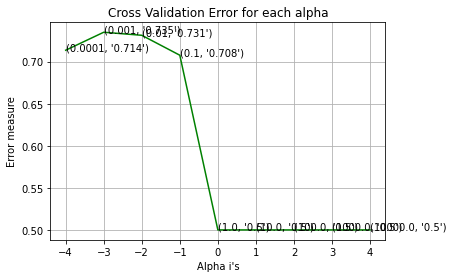

The Optimal C value is: 0.001


In [ ]:
alpha = np.logspace(-4,4,9)
cv_auc_score = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1',class_weight = 'balanced', loss='log', random_state=28)
    clf.fit(X_train_final[selected_features], y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train_final[selected_features], y_train)
    y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features])[:,1]
    cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
    print('For alpha {0}, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))
cv_plot(alpha, cv_auc_score)
print('The Optimal C value is:', alpha[np.argmax(cv_auc_score)])


For best alpha 0.001, The Train AUC score is 0.7426509786305403
For best alpha 0.001, The Cross validated AUC score is 0.7349219872585547
For best alpha 0.001, The Test AUC score is 0.7345923119570626
The test AUC score is : 0.7345923119570626
The percentage of misclassified points 28.39% :


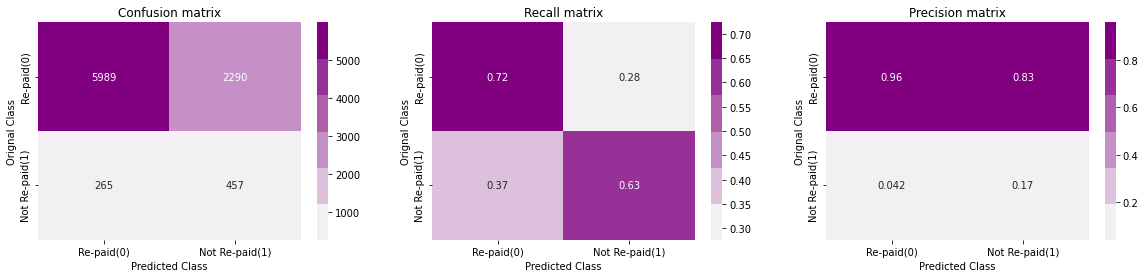

In [ ]:
best_alpha = alpha[np.argmax(cv_auc_score)]
logreg = SGDClassifier(alpha = best_alpha, class_weight = 'balanced', penalty = 'l1', loss='log', random_state = 28)
logreg.fit(X_train_final[selected_features], y_train)
logreg_sig_clf = CalibratedClassifierCV(logreg, method='sigmoid')
logreg_sig_clf.fit(X_train_final[selected_features], y_train)
y_pred_prob = logreg_sig_clf.predict_proba(X_train_final[selected_features])[:,1]
print('For best alpha {0}, The Train AUC score is {1}'.format(best_alpha, roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = logreg_sig_clf.predict_proba(X_val_final[selected_features])[:,1]
print('For best alpha {0}, The Cross validated AUC score is {1}'.format(best_alpha, roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = logreg_sig_clf.predict_proba(X_test_final[selected_features])[:,1]
print('For best alpha {0}, The Test AUC score is {1}'.format(best_alpha, roc_auc_score(y_test,y_pred_prob) ))
y_pred = logreg.predict(X_test_final[selected_features])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

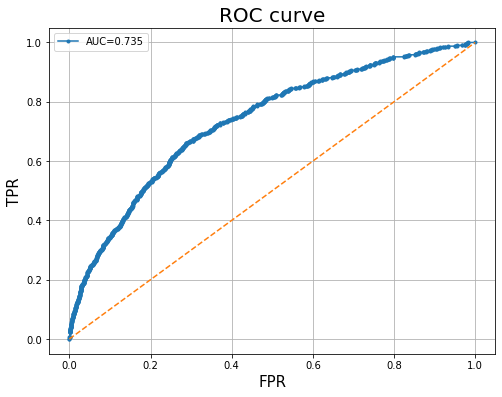

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

# **random forest**

In [ ]:
alpha = [200,500]
max_depth = [7, 10]
cv_auc_score = []
for i in alpha:
    for j in max_depth:
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j,class_weight='balanced',
                                     random_state=42, n_jobs=-1)
        clf.fit(X_train_final[selected_features], y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(X_train_final[selected_features], y_train)
        y_pred_prob = sig_clf.predict_proba(X_val_final[selected_features])[:,1]
        cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
        print('For n_estimators {0}, max_depth {1} cross validation AUC score {2}'.
              format(i,j,roc_auc_score(y_val,y_pred_prob)))

For n_estimators 200, max_depth 7 cross validation AUC score 0.7332498315128241
For n_estimators 200, max_depth 10 cross validation AUC score 0.7260582567416621
For n_estimators 500, max_depth 7 cross validation AUC score 0.733272921115877
For n_estimators 500, max_depth 10 cross validation AUC score 0.7268730854870802


The optimal values are: n_estimators 500, max_depth 7 
For best n_estimators 500 best max_depth 7, The Train AUC score is 0.8129782546754388
For best n_estimators 500 best max_depth 7, The Validation AUC score is 0.733272921115877
For best n_estimators 500 best max_depth 7, The Test AUC score is 0.7266360604660391
The test AUC score is : 0.7266360604660391
The percentage of misclassified points 08.02% :


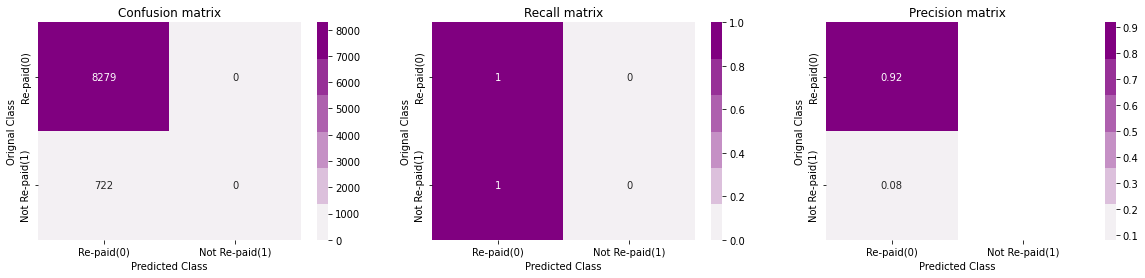

In [ ]:
best_alpha = np.argmax(cv_auc_score)
print('The optimal values are: n_estimators {0}, max_depth {1} '.format(alpha[int(best_alpha/2)],
                                                                        max_depth[int(best_alpha%2)]))
rf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)],
                            class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train_final[selected_features], y_train)
rf_sig_clf = CalibratedClassifierCV(rf, method="sigmoid")
rf_sig_clf.fit(X_train_final[selected_features], y_train)
y_pred_prob = rf_sig_clf.predict_proba(X_train_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Train AUC score is {2}'.format(alpha[int(best_alpha/2)], 
                                                    max_depth[int(best_alpha%2)],roc_auc_score(y_train,y_pred_prob)))
y_pred_prob = rf_sig_clf.predict_proba(X_val_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Validation AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                            max_depth[int(best_alpha%2)],roc_auc_score(y_val,y_pred_prob)))
y_pred_prob = rf_sig_clf.predict_proba(X_test_final[selected_features])[:,1]
print('For best n_estimators {0} best max_depth {1}, The Test AUC score is {2}'.format(alpha[int(best_alpha/2)],
                                                        max_depth[int(best_alpha%2)],roc_auc_score(y_test,y_pred_prob)))
y_pred = rf_sig_clf.predict(X_test_final[selected_features])
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.919786690367737

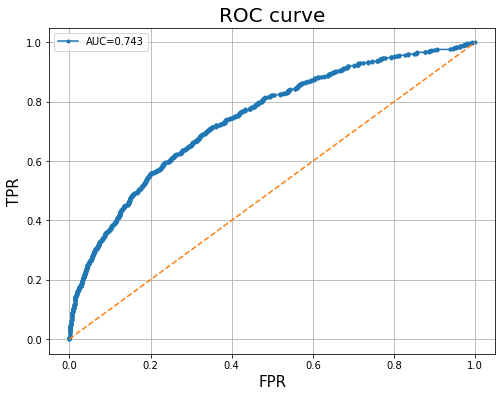

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [ ]:
with open('final_model.pkl','wb') as fp:
    pickle.dump(rf_sig_clf, fp)

Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.711633
[20]	valid_0's auc: 0.716192
[30]	valid_0's auc: 0.72211
[40]	valid_0's auc: 0.725698
[50]	valid_0's auc: 0.728846
[60]	valid_0's auc: 0.732445
[70]	valid_0's auc: 0.735071
[80]	valid_0's auc: 0.737059
[90]	valid_0's auc: 0.7379
[100]	valid_0's auc: 0.739137
[110]	valid_0's auc: 0.740549
[120]	valid_0's auc: 0.741753
[130]	valid_0's auc: 0.742956
[140]	valid_0's auc: 0.743674
[150]	valid_0's auc: 0.744607
[160]	valid_0's auc: 0.745451
[170]	valid_0's auc: 0.746546
[180]	valid_0's auc: 0.747415
[190]	valid_0's auc: 0.747825
[200]	valid_0's auc: 0.748349
[210]	valid_0's auc: 0.748738
[220]	valid_0's auc: 0.74938
[230]	valid_0's auc: 0.749836
[240]	valid_0's auc: 0.750277
[250]	valid_0's auc: 0.750797
[260]	valid_0's auc: 0.751179
[270]	valid_0's auc: 0.751766
[280]	valid_0's auc: 0.752088
[290]	valid_0's auc: 0.752516
[300]	valid_0's auc: 0.752763
[310]	valid_0's auc: 0.753147
[320]	valid_0's auc:

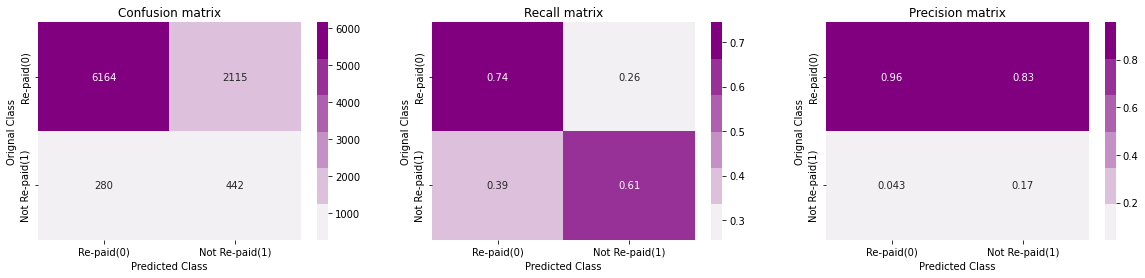

In [ ]:
weight = np.ones((len(X_train_final),), dtype=int)
for i in range(len(X_train_final)):
    if y_train[i]== 0:
        weight[i]=1
    else:
        weight[i]=11

train_data=lgb.Dataset(X_train_final[selected_features], label = y_train, weight= weight )
valid_data=lgb.Dataset(X_val_final[selected_features], label = y_val)
cv_auc_score = []
max_depth = [3, 5, 7, 10]
for i in max_depth:
    
    params = {'boosting_type': 'gbdt',
          'max_depth' : i,
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
    lgbm=lgb.train(
        params,
        train_data,
        2500,
        valid_sets=valid_data,
        early_stopping_rounds= 100,
        verbose_eval= 10
    )

    y_pred_prob = lgbm.predict(X_val_final[selected_features])
    cv_auc_score.append(roc_auc_score(y_val,y_pred_prob))
    print('For  max_depth {0} and some other parameters, cross validation AUC score {1}'.format(i,roc_auc_score(y_val,y_pred_prob)))

print('The optimal  max_depth: ', max_depth[np.argmax(cv_auc_score)])

params = {'boosting_type': 'gbdt',
          'max_depth' : max_depth[np.argmax(cv_auc_score)],
          'objective': 'binary',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.05,
          'max_bin': 512,
          'subsample_for_bin': 200,
          'subsample': 0.7,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'reg_alpha': 20,
          'reg_lambda': 20,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 10,
          'scale_pos_weight': 1,
          'num_class' : 1,
          'metric' : 'auc'
          }
lgbm = lgb.train(params,
                 train_data,
                 2500,
                 valid_sets=valid_data,
                 early_stopping_rounds= 100,
                 verbose_eval= 10
                 )
y_pred_prob = lgbm.predict(X_train_final[selected_features])
print('For best max_depth {0}, The Train AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                  roc_auc_score(y_train,y_pred_prob) ))    
y_pred_prob = lgbm.predict(X_val_final[selected_features])
print('For best max_depth {0}, The Cross validated AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                            roc_auc_score(y_val,y_pred_prob) ))  
y_pred_prob = lgbm.predict(X_test_final[selected_features])
print('For best max_depth {0}, The Test AUC score is {1}'.format(max_depth[np.argmax(cv_auc_score)], 
                                                                 roc_auc_score(y_test,y_pred_prob) ))
y_pred = np.ones((len(X_test_final),), dtype=int)
for i in range(len(y_pred_prob)):
    if y_pred_prob[i]<=0.5:
        y_pred[i]=0
    else:
        y_pred[i]=1
print('The test AUC score is :', roc_auc_score(y_test,y_pred_prob))
print('The percentage of misclassified points {:05.2f}% :'.format((1-accuracy_score(y_test, y_pred))*100))
plot_confusion_matrix(y_test, y_pred)

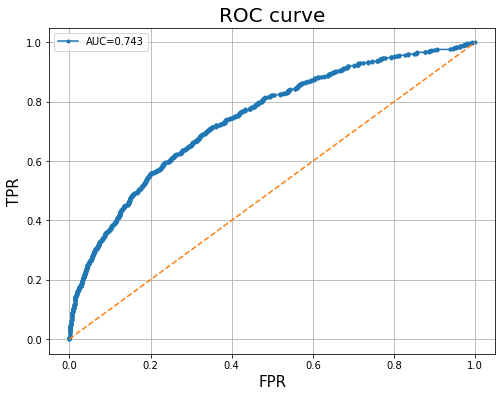

In [ ]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test,y_pred_prob)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, marker='.')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC curve', fontsize = 20)
plt.xlabel('FPR', fontsize=15)
plt.ylabel('TPR', fontsize=15)
plt.grid()
plt.legend(["AUC=%.3f"%auc])
plt.show()

In [ ]:
with open('final_model_2.pkl','wb') as fp:
    pickle.dump(lgbm, fp)

In [ ]:
x_test

NameError: ignored

In [ ]:
x_train

NameError: ignored

0       -0.579613
1        0.796907
2        0.796907
3       -0.579613
4        0.796907
           ...   
41995   -0.579613
41996   -0.579613
41997   -0.579613
41998   -0.579613
41999    0.796907
Name: CNT_CHILDREN, Length: 42000, dtype: float64

In [ ]:
send_to_kammy=X_train_final[selected_features].head(20)

In [ ]:
send_to_kammy.to_csv('kammy.csv')

In [20]:
with open('/content/drive/MyDrive/project/final_model.pkl','rb') as f:
  model=pickle.load(f)

In [11]:
X_train_final=pd.read_csv('/content/drive/MyDrive/project/X_train_final.csv')
y_train=pd.read_csv('/content/drive/MyDrive/project/y_train.txt')

In [15]:
with open('/content/drive/MyDrive/project/select_features.txt','rb') as f:
  selected_features=pickle.load(f)
selected_features=selected_features[:20]
x_train=x_train[selected_features]
y_train=y_train[selected_features]

EOFError: ignored

In [21]:
model

CalibratedClassifierCV(base_estimator=RandomForestClassifier(class_weight='balanced',
                                                             max_depth=7,
                                                             n_estimators=500,
                                                             n_jobs=-1,
                                                             random_state=42))

In [4]:
!pip install -U ibm-watson-machine-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 15.9 MB/s 
     |████████████████████████████████| 51 kB 370 kB/s 
     |████████████████████████████████| 824 kB 43.9 MB/s 
     |████████████████████████████████| 133 kB 52.2 MB/s 
     |████████████████████████████████| 547 kB 36.4 MB/s 
  Created wheel for ibm-cos-sdk: filename=ibm_cos_sdk-2.7.0-py2.py3-none-any.whl size=72564 sha256=8cf99be8ead08876cf61818ed1247f5b6a8ccb97fa7be70f5d773be57b14930b
  Stored in directory: /root/.cache/pip/wheels/47/22/bf/e1154ff0f5de93cc477acd0ca69abfbb8b799c5b28a66b44c2
  Created wheel for ibm-cos-sdk-core: filename=ibm_cos_sdk_core-2.7.0-py2.py3-none-any.whl size=501013 sha256=9eae029a125a4d1fe232f04534b187d94b96dfcc146ef02af79bcecc3b7e2d39
  Stored in directory: /root/.cache/pip/wheels/6c/a2/e4/c16d02f809a3ea998e17cfd02c13369281f3d232aaf5902c19
  Created wheel for ibm-cos-sdk-s3transfer: filename=ibm_cos

In [5]:
from ibm_watson_machine_learning import APIClient
import json
import numpy as np

In [6]:
vml_credential={
    'apikey':'gwUVQsmIWTA2wWdBeU7q-wK4Kdb87qG5Q-bFHZyg5RdD',
    'url':"https://us-south.ml.cloud.ibm.com"
}

In [7]:
wml_client = APIClient(vml_credential)
wml_client.spaces.list()

Python 3.7 and 3.8 frameworks are deprecated and will be removed in a future release. Use Python 3.9 framework instead.
Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  ----------------  ------------------------
ID                                    NAME              CREATED
88d917f9-ab7a-4992-b335-c84b9e0e3f1d  House credit san  2022-09-07T23:05:59.177Z
86d23858-2e24-419f-9290-f652894d2272  Personalloan      2022-09-07T22:09:51.952Z
------------------------------------  ----------------  ------------------------


In [8]:
space_id='88d917f9-ab7a-4992-b335-c84b9e0e3f1d'
wml_client.set.default_space(space_id)

'SUCCESS'

In [22]:
MODEL_NAME = 'lightgbm'
DEPLOYMENT_NAME = 'ML house Deployment'
BEST_MODEL = model

In [23]:
software_spec_uid = wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

#Save model
model_details = wml_client.repository.store_model(model=BEST_MODEL, meta_props=model_props, training_data=None)

In [24]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-09-07T23:39:18.926Z',
  'id': 'df01d234-40ae-46f1-83f3-1bceb598fc9c',
  'modified_at': '2022-09-07T23:39:42.611Z',
  'name': 'lightgbm',
  'owner': 'IBMid-6660024OWF',
  'resource_key': 'f2e17920-6fe0-412a-8dc3-6738d24d31d7',
  'space_id': '88d917f9-ab7a-4992-b335-c84b9e0e3f1d'},
 'system': {'warnings': []}}

In [25]:
model_uid = wml_client.repository.get_model_id(model_details)

In [26]:
model_uid

'df01d234-40ae-46f1-83f3-1bceb598fc9c'